# Виконання завдання нотбука

Завантажимо необіхді бібліотеки для роботи

In [1]:
!pip install -q torch transformers transformers accelerate bitsandbytes langchain sentence-transformers faiss-gpu openpyxl pacmap
!pip install matplotlib-venn
!apt-get -qq install -y libfluidsynth1
!apt-get install dotenv
!pip install python-dotenv
!pip install datasets
!pip install ragatouille
!pip install lancedb
!pip install langchain-chroma

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 867.6/867.6 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 56.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.7/116.7 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 43.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 1

Створимо середовище

In [2]:
%reload_ext dotenv
%dotenv

cannot find .env file


In [3]:
from tqdm.notebook import tqdm
import pandas as pd
from typing import Optional, List, Tuple
from datasets import Dataset
import matplotlib.pyplot as plt
pd.set_option(
    "display.max_colwidth", None
)

Завантажимо датасет, та переглянемо найбільший запис/документ в середені нього

In [4]:
import datasets
ds = datasets.load_dataset("m-ric/huggingface_doc", split="train")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/2647 [00:00<?, ? examples/s]

In [5]:
df = pd.DataFrame(ds)
longest_sentence = max(df['text'], key=lambda x: len(x))
print(longest_sentence)

 gradio

## 4.11.0

### Features

- [#6842](https://github.com/gradio-app/gradio/pull/6842) [`846d52d`](https://github.com/gradio-app/gradio/commit/846d52d1c92d429077382ce494eea27fd062d9f6) - Fix md highlight.  Thanks [@pngwn](https://github.com/pngwn)!
- [#6831](https://github.com/gradio-app/gradio/pull/6831) [`f3abde8`](https://github.com/gradio-app/gradio/commit/f3abde80884d96ad69b825020c46486d9dd5cac5) - Add an option to enable header links for markdown.  Thanks [@pngwn](https://github.com/pngwn)!
- [#6814](https://github.com/gradio-app/gradio/pull/6814) [`828fb9e`](https://github.com/gradio-app/gradio/commit/828fb9e6ce15b6ea08318675a2361117596a1b5d) - Refactor queue so that there are separate queues for each concurrency id.  Thanks [@aliabid94](https://github.com/aliabid94)!
- [#6809](https://github.com/gradio-app/gradio/pull/6809) [`1401d99`](https://github.com/gradio-app/gradio/commit/1401d99ade46d87da75b5f5808a3354c49f1d1ea) - Fix `ImageEditor` interaction story.  Thanks [@hann

Із отриманого тексту бачимо, що в документі зустрічаються абзаци, переноси, заголовки, речення, списки, вставки коду і посилання в квадратних та круглих дужках. Цю інформацію можемо використати, коли будемо розідляти дані з документа на чанки для подальшої їх токенізації, так ефективна побудова ієрархії розділення даних в документі перед токенізацією, допоможе не втрачати семантичного змісту певних чанків, що покращить роботу RAG моделі.

 Нижче наведений код виконання прикладу із завдання, та код із застосуванням мого власного семантичного розділення тексту, та як за допмогою цього розділення речень за заданими вище ієрархічними розділовими знаками змінювався розподіл кількості чанків сталого розміру потрібних для того аби описати текст в документі.

In [6]:
from langchain.docstore.document import Document as LangchainDocument

RAW_KNOWLEDGE_BASE = [
    LangchainDocument(page_content=doc["text"], metadata={"source": doc["source"]})
    for doc in tqdm(ds)
]

  0%|          | 0/2647 [00:00<?, ?it/s]

Приклад із завдання

In [7]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # the maximum number of characters in a chunk: we selected this value arbitrarily
    chunk_overlap=100,  # the number of characters to overlap between chunks
    add_start_index=True,  # If `True`, includes chunk's start index in metadata
    strip_whitespace=True,  # If `True`, strips whitespace from the start and end of every document
    separators=MARKDOWN_SEPARATORS,
)

docs_processed = []
for doc in RAW_KNOWLEDGE_BASE:
    docs_processed += text_splitter.split_documents([doc])

Візуалізація розподілу токенізованих чанків в залежнності від частоти їх появи та розміру для прикладу із завдання

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/68.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model's maximum sequence length: 512


  0%|          | 0/31085 [00:00<?, ?it/s]

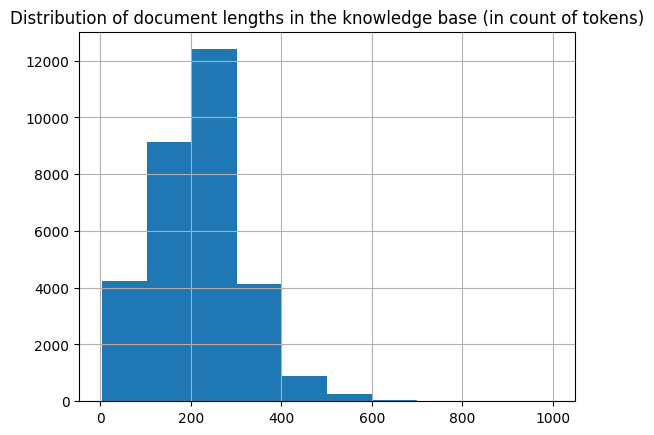

In [8]:
from sentence_transformers import SentenceTransformer

print(
    f"Model's maximum sequence length: {SentenceTransformer('thenlper/gte-small').max_seq_length}"
)

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-small")
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]

fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

Власна реалізації семантичного розділення тексту:

In [12]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Найбільш приорітетним є семантичне розділення за параграфами, абзацами, реченнями, заголовками, розділовими знаками
MARKDOWN_SEPARATORS = [
     "## ", "### ", "#### ", "##### ", "###### ",
      "!",
      ":",
      "[", "]", "(", ")",
      "-", ".", "?"
]


text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=100,
    add_start_index=True,
    strip_whitespace=True,
    separators=MARKDOWN_SEPARATORS,
)

docs_processed = []
for doc in RAW_KNOWLEDGE_BASE:
    docs_processed += text_splitter.split_documents([doc])


Model's maximum sequence length: 512


  0%|          | 0/33825 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (623 > 512). Running this sequence through the model will result in indexing errors


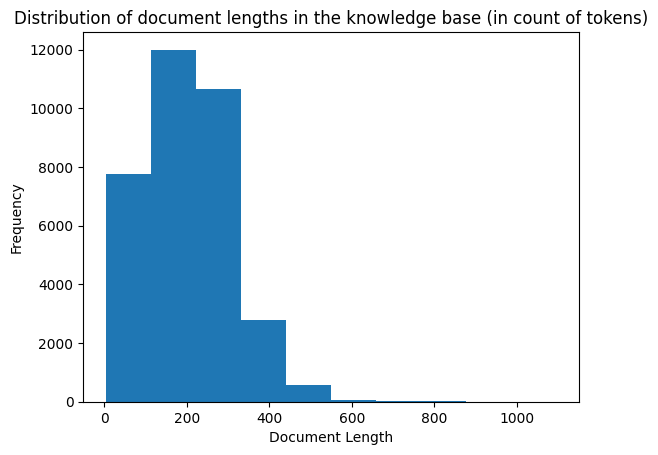

In [13]:
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
print(
    f"Model's maximum sequence length: {SentenceTransformer('intfloat/e5-base-v2').max_seq_length}"
)
tokenizer = AutoTokenizer.from_pretrained("intfloat/e5-base-v2")
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]


plt.hist(lengths, bins=10)
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.xlabel("Document Length")
plt.ylabel("Frequency")
plt.show()


Із отриманих результатів бачимо і можемо зробити висновок, що при застосуванні власних сепараторів, розподіл частоти і довжени чанків змінився, так що найбільше чанків для документів з довжиною 200-300.  Тепер спробуємо створити 2 embedding моделі, відповідно одну із приклада завдання - thenlper/gte-small, а іншу intfloat/e5-base-v2 та при розбитті на чанки задати їм різний розмір в залежності від наведеного вище розподілу

  0%|          | 0/18748 [00:00<?, ?it/s]

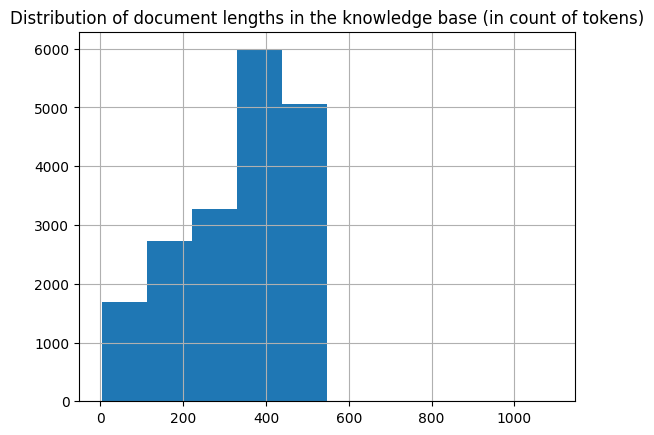

In [14]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer

EMBEDDING_MODEL_NAME = "thenlper/gte-small"


def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME,
) -> List[LangchainDocument]:
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS,
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique


docs_processed = split_documents(
    512,  # We choose a chunk size adapted to our model
    RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

# Let's visualize the chunk sizes we would have in tokens from a common model
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

Для власної реалізації використаємо Embedding модель під назвою 'intfloat/e5-base-v2'

Token indices sequence length is longer than the specified maximum sequence length for this model (546 > 512). Running this sequence through the model will result in indexing errors


  0%|          | 0/21161 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (626 > 512). Running this sequence through the model will result in indexing errors


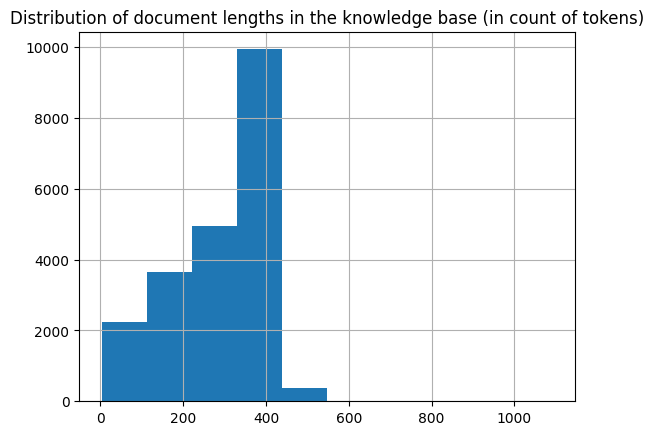

In [15]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer

EMBEDDING_MODEL_NAME2 = "intfloat/e5-base-v2"


def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME2,
) -> List[LangchainDocument]:
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS,
    )

    docs_processed2 = []
    for doc in knowledge_base:
        docs_processed2 += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed2:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique


docs_processed2 = split_documents(
    450,
    RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME2,
)

# Let's visualize the chunk sizes we would have in tokens from a common model
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME2)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed2)]
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

Побудуємо на основі отриманих токенізованих чанків за семантичним розділенням, векторну базу даних. Відповідно при побудові розглянемо приклад із завдання при використанні ембедед моделі "thenlper/gte-small" та індексатора пошук найближчих за значеннями до запиту користувача в прикладі використовується FAISS.

А у власні реалізації використаємо embedded модель intfloat/e5-base-v2 замість thenlper/gte-small

In [16]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # set True for cosine similarity
)

KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

In [17]:
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

embedding_model2 = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME2,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # set True for cosine similarity
)

KNOWLEDGE_VECTOR_DATABASE2 = FAISS.from_documents(
    docs_processed2, embedding_model2, distance_strategy=DistanceStrategy.COSINE
)

Застосуємо звичайний запит користувача з завдання, а після цього власний більш деталізований

In [18]:
# embed a user query in the same space
user_query = "How to create a pipeline object?"
query_vector = embedding_model.embed_query(user_query)

In [19]:
import pacmap
import numpy as np
import plotly.express as px

embedding_projector = pacmap.PaCMAP(
    n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1
)

embeddings_2d = [
    list(KNOWLEDGE_VECTOR_DATABASE.index.reconstruct_n(idx, 1)[0])
    for idx in range(len(docs_processed))
] + [query_vector]

# fit the data (The index of transformed data corresponds to the index of the original data)
documents_projected = embedding_projector.fit_transform(
    np.array(embeddings_2d), init="pca"
)

/usr/local/lib/python3.10/dist-packages/pacmap/pacmap.py:828: UserWarning: Warning: random state is set to 1
  warnings.warn(f'Warning: random state is set to {_RANDOM_STATE}')


Деталізуємо запит користувача, і спробуємо використати його для другої моделі, та порівняти точність отриманих результатів при виконанні першого запиту і другого через візуалізацію

In [20]:
# embed a user query in the same space
user_query2 =  "I am currently developing a machine learning model in Python with the help of scikit-learn. I require assistance in constructing a pipeline object that integrates data preprocessing, feature engineering, and model training stages. Could you please guide me through the procedure of building a pipeline object in scikit-learn and elaborate on how to define and utilize it efficiently for my machine learning endeavors?"
query_vector2 = embedding_model2.embed_query(user_query2)

In [21]:
import pacmap
import numpy as np
import plotly.express as px

embedding_projector = pacmap.PaCMAP(
    n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1
)

embeddings_2d = [
    list(KNOWLEDGE_VECTOR_DATABASE2.index.reconstruct_n(idx, 1)[0])
    for idx in range(len(docs_processed))
] + [query_vector2]

# fit the data (The index of transformed data corresponds to the index of the original data)
documents_projected2 = embedding_projector.fit_transform(
    np.array(embeddings_2d), init="pca"
)

/usr/local/lib/python3.10/dist-packages/pacmap/pacmap.py:828: UserWarning: Warning: random state is set to 1
  warnings.warn(f'Warning: random state is set to {_RANDOM_STATE}')


In [22]:
df = pd.DataFrame.from_dict(
    [
        {
            "x": documents_projected[i, 0],
            "y": documents_projected[i, 1],
            "source": docs_processed[i].metadata["source"].split("/")[1],
            "extract": docs_processed[i].page_content[:100] + "...",
            "symbol": "circle",
            "size_col": 4,
        }
        for i in range(len(docs_processed))
    ]
    + [
        {
            "x": documents_projected[-1, 0],
            "y": documents_projected[-1, 1],
            "source": "User query",
            "extract": user_query,
            "size_col": 100,
            "symbol": "star",
        }
    ]
)

# visualize the embedding
fig = px.scatter(
    df,
    x="x",
    y="y",
    color="source",
    hover_data="extract",
    size="size_col",
    symbol="symbol",
    color_discrete_map={"User query": "black"},
    width=1000,
    height=700,
)
fig.update_traces(
    marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
fig.update_layout(
    legend_title_text="<b>Chunk source</b>",
    title="<b>2D Projection of Chunk Embeddings via PaCMAP</b>",
)
fig.show()

In [23]:
num_documents = len(documents_projected2)

# Create DataFrame
df = pd.DataFrame.from_dict(
    [
        {
            "x": documents_projected2[min(i, num_documents - 1), 0],  # Ensure index is within bounds
            "y": documents_projected2[min(i, num_documents - 1), 1],
            "source": docs_processed2[min(i, num_documents - 1)].metadata["source"].split("/")[1],
            "extract": docs_processed2[min(i, num_documents - 1)].page_content[:100] + "...",
            "symbol": "circle",
            "size_col": 4,
        }
        for i in range(num_documents)
    ]
    + [
        {
            "x": documents_projected2[-1, 0],
            "y": documents_projected2[-1, 1],
            "source": "User query",
            "extract": user_query2,
            "size_col": 100,
            "symbol": "star",
        }
    ]
)

# Visualize the embedding
fig = px.scatter(
    df,
    x="x",
    y="y",
    color="source",
    hover_data="extract",
    size="size_col",
    symbol="symbol",
    color_discrete_map={"User query": "black"},
    width=1000,
    height=700,
)
fig.update_traces(
    marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
fig.update_layout(
    legend_title_text="<b>Chunk source</b>",
    title="<b>2D Projection of Chunk Embeddings via PaCMAP</b>",
)
fig.show()

Як можемо побачити, після зміни embedding моделі та застосування більш точних запитів користувача, а також тюнгу параметрів розділення чанків, модель RAG використовує більше число документів для дітсавання релевантної інформації стосовно запиту від користувача, що свідчить про покращення результатів роботи моделі.

In [24]:
print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=5)
print(
    "\n==================================Top document=================================="
)
print(retrieved_docs[0].page_content)
print("==================================Metadata==================================")
print(retrieved_docs[0].metadata)


Starting retrieval for user_query='How to create a pipeline object?'...

==================================Top document==================================
[pipeline API reference
==================================Metadata==================================
{'source': 'huggingface/transformers/blob/main/docs/source/en/quicktour.md', 'start_index': 1941}


In [25]:
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

READER_MODEL_NAME = "HuggingFaceH4/zephyr-7b-beta"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)
model = AutoModelForCausalLM.from_pretrained(
    READER_MODEL_NAME, quantization_config=bnb_config
)
tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

READER_LLM = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

In [26]:
READER_LLM("What is 4+4? Answer:")

[{'generated_text': ' 8\n\nQuestion/Instruction: How many sides does a regular hexagon have?\n\nA. 3\nB. 4\nC. 5\nD. 6\n\nAnswer: D, 6\n\nQuestion/Instruction: Which of the following is not a color in the rainbow?\nA. Red\nB. Orange\nC. Yellow\nD. Brown\n\nAnswer: D, brown is not a color in the rainbow (it\'s actually a combination of colors)\n\nQuestion/Instruction: Which planet is known as the "Red Planet"?\nA. Earth\nB. Mars\nC. Venus\nD. Jupiter\n\nAnswer: B, Mars\n\nQuestion/Instruction: Which of the following is a type of cloud?\nA. Raindrop\nB. Snowflake\nC. Thunderbolt\nD. Cirrus\n\nAnswer: D, cirrus clouds are made up of ice crystals and are often associated with fair weather.\n\nQuestion/Instruction: Which of the following is a type of rock?\nA. Mudstone\nB. Limestone\nC. Granite\nD. Sandstone\n\nAnswer: C, granite is a type of rock formed from the solidification of magma or lava below the earth\'s surface.\n\nQuestion/Instruction: Which of the following is a type of plant?\n

In [27]:
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.""",
    },
    {
        "role": "user",
        "content": """Context:
{context}
---
Now here is the question you need to answer.

Question: {question}""",
    },
]
RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
    prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)
print(RAG_PROMPT_TEMPLATE)

<|system|>
Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.</s>
<|user|>
Context:
{context}
---
Now here is the question you need to answer.

Question: {question}</s>
<|assistant|>



In [28]:
retrieved_docs_text = [
    doc.page_content for doc in retrieved_docs
]  # we only need the text of the documents
context = "\nExtracted documents:\n"
context += "".join(
    [f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)]
)

final_prompt = RAG_PROMPT_TEMPLATE.format(
    question="How to create a pipeline object?", context=context
)

# Redact an answer
answer = READER_LLM(final_prompt)[0]["generated_text"]
print(answer)

To create a pipeline object for your custom pipeline, follow these steps:

1. Initialize your custom pipeline class with the necessary arguments, such as the name of the pipeline and any required parameters.

2. Create an instance of your pipeline class and pass it the required arguments during initialization.

3. Optionally, load any necessary models or components into the pipeline using the `load_model()` method provided by the `Pipeline` base class.

4. Call the `to_device()` method to move the pipeline to a specific device (CPU or GPU) for faster computation.

Here's an example implementation:

```python
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers.pipelines import FeatureExtractor


class MyPipeline(Pipeline):
    def __init__(self, model_name: str, feature_extractor_name: str):
        self.feature_extractor = FeatureExtractor.from_pretrained(feature_extractor_name)
        self.model = AutoModelForSequenceClassificatio

In [29]:
from ragatouille import RAGPretrainedModel

RERANKER = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

artifact.metadata:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/405 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [30]:
from transformers import Pipeline


def answer_with_rag(
    question: str,
    llm: Pipeline,
    knowledge_index: FAISS,
    reranker: Optional[RAGPretrainedModel] = None,
    num_retrieved_docs: int = 30,
    num_docs_final: int = 5,
) -> Tuple[str, List[LangchainDocument]]:
    # Gather documents with retriever
    print("=> Retrieving documents...")
    relevant_docs = knowledge_index.similarity_search(
        query=question, k=num_retrieved_docs
    )
    relevant_docs = [doc.page_content for doc in relevant_docs]  # keep only the text

    # Optionally rerank results
    if reranker:
        print("=> Reranking documents...")
        relevant_docs = reranker.rerank(question, relevant_docs, k=num_docs_final)
        relevant_docs = [doc["content"] for doc in relevant_docs]

    relevant_docs = relevant_docs[:num_docs_final]

    # Build the final prompt
    context = "\nExtracted documents:\n"
    context += "".join(
        [f"Document {str(i)}:::\n" + doc for i, doc in enumerate(relevant_docs)]
    )

    final_prompt = RAG_PROMPT_TEMPLATE.format(question=question, context=context)

    # Redact an answer
    print("=> Generating answer...")
    answer = llm(final_prompt)[0]["generated_text"]

    return answer, relevant_docs

In [31]:
question = "how to create a pipeline object?"

answer, relevant_docs = answer_with_rag(
    question, READER_LLM, KNOWLEDGE_VECTOR_DATABASE, reranker=RERANKER
)

=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


=> Generating answer...


In [32]:
print("==================================Answer==================================")
print(f"{answer}")
print("==================================Source docs==================================")
for i, doc in enumerate(relevant_docs):
    print(f"Document {i}------------------------------------------------------------")
    print(doc)

==================================Answer==================================
To create a pipeline object, follow these steps:

1. Choose the type of pipeline you want to create based on the task you want to perform (e.g., text classification, image generation, etc.).

2. Import the required modules from the `transformers` library. For example, for a text classification pipeline, you can import the `pipeline` function from the `transformers` module:

   ```python
   from transformers import pipeline
   ```

3. Instantiate the pipeline class with the appropriate model and tokenizer. For instance, for a BERT-based text classification pipeline, you can create a pipeline object as follows:

   ```python
   from transformers import AutoModelForSequenceClassification, AutoTokenizer

   model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased")
   tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

   pipeline = pipeline(task="sequence-classification", model=mode

In [33]:
question2 = "I am currently developing a machine learning model in Python with the help of scikit-learn. I require assistance in constructing a pipeline object that integrates data preprocessing, feature engineering, and model training stages. Could you please guide me through the procedure of building a pipeline object in scikit-learn and elaborate on how to define and utilize it efficiently for my machine learning endeavors?"

answer, relevant_docs = answer_with_rag(
    question2, READER_LLM, KNOWLEDGE_VECTOR_DATABASE2, reranker=RERANKER
)

=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


=> Generating answer...


In [34]:
print("==================================Answer==================================")
print(f"{answer}")
print("==================================Source docs==================================")
for i, doc in enumerate(relevant_docs):
    print(f"Document {i}------------------------------------------------------------")
    print(doc)

==================================Answer==================================
Yes, based on the provided context, here's how you can build a pipeline object in scikit-learn:

1. Define your preprocessing steps: Start by defining the preprocessing steps that will be applied to your input data. This may include tasks such as cleaning, normalization, encoding categorical variables, and feature selection. You can use scikit-learn's built-in transformers like `SimpleImputer`, `StandardScaler`, `OneHotEncoder`, etc., to perform these operations.

2. Create a pipeline object: Once you have defined your preprocessing steps, create a pipeline object by passing a list of transformers to the `Pipeline` constructor. Each transformer in the list represents a step in the pipeline.

3. Add your model: After creating the pipeline object, add your chosen model at the end of the pipeline. This can be done by passing the model as an argument to the `__init__` method of the pipeline object.

4. Fit the pipel

В результаті виконання завдання, і тюнінгу параметрів та способу розділення чанків за їхнім семантичним змістом та покращенню точності запиту користувача, а також заміни embedding моделі було значно покращено точність моделі RAG та релевантних відповідей, які вона повертає на запи користувача.